# Setup

In [2]:
import ollama
from PIL import Image
import io
import base64
import os
import json
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import lancedb
from lancedb.embeddings import get_registry
from lancedb.pydantic import LanceModel, Vector
from lancedb.rerankers import ColbertReranker
from tqdm.notebook import tqdm
import torch

#TODO: Create custom LanceDB query function which combines vector search for the image and text embeddings. Also check if we should use Hybrid with reranking or just vector search.

In [4]:




# Configure pipeline to only extract embedded pictures
pipeline_options = PdfPipelineOptions()
pipeline_options.images_scale = 3.0   # adjust DPI scaling (2.0 ≈ 144 DPI)
pipeline_options.generate_picture_images = True
pipeline_options.generate_page_images = False  # <-- disable page renders

doc_converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
    }
)

# Load embedding models
image_embedding_model_name = "sentence-transformers/clip-ViT-B-32"
text_embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
registry = get_registry()
clip = registry.get("open-clip").create(device="cuda" if torch.cuda.is_available() else "cpu")
text_embedding_model = registry.get("huggingface").create(name=text_embedding_model_name, trust_remote_code=True, device="cuda" if torch.cuda.is_available() else "cpu")

study_names = [f for f in os.listdir("input") if f.endswith('.pdf')]
with open("image_chunks.json", "r", encoding="utf-8") as f:
    processed_chunks = json.load(f)

chunks_with_metadata = processed_chunks.copy()
processed_studies = set(chunk["document"] for chunk in processed_chunks)
study_names = [f for f in study_names if f not in processed_studies]
print(f"Found {len(processed_studies)} studies which are already processed.\nStudies which STILL need to be processed: {len(study_names)}:\n{study_names}...")

Found 25 studies which are already processed.
Studies which STILL need to be processed: 0:
[]...


# Define DB Schema

In [5]:
# Define model
class ImageModel(LanceModel):
    image_uri: str = clip.SourceField()  # As much as I dislike it, we should store the URI to the image instead of the image itself. This can also double as a unique ID.
    vector: Vector(clip.ndims()) = clip.VectorField()
    description: str = text_embedding_model.SourceField()
    description_vector: Vector(text_embedding_model.ndims()) = text_embedding_model.VectorField()
    document: str
    page: int

    @property
    def image(self):
        return Image.open(self.image_uri)

db = lancedb.connect("./db")
# db.create_table("my_image_table", schema=ImageModel, mode="overwrite") # Uncomment this line when running this cell for the first time
table = db.open_table("my_image_table")


# Process corpus for images

In [3]:
for source in tqdm(study_names, desc="Chunking documents..."):
    doc = doc_converter.convert(f"input/{source}").document

    # Extract only embedded images (e.g., graphs/figures)
    for pic in tqdm(doc.pictures, desc=f"Processing images in {source[:20]}...", leave=False):
        if pic.image:  # each PictureItem has a PIL image
            pil_img = pic.image.pil_image
            buf = io.BytesIO() 
            pil_img.save(buf, format="PNG") # Convert image to raw bytes
            image_bytes = buf.getvalue()
            image_b64 = base64.b64encode(image_bytes).decode("utf-8")
            

            response = ollama.chat(
                model="gemma3:4b-it-qat",
                messages=[
                    {"role": "user", "content": "Is this image a logo/brand? If yes, output \"skip\". Else, describe the contents of the image. Try to limit your description to at most 200 word pieces.", "images": [image_b64]}
                ],
            )

            response = response["message"]['content'].strip()
            if "skip" == response.lower():
                print("Skipping logo/brand image.")
                continue
            else:

            # derive a filename (can include page number from provenance if needed)
                page = pic.prov[0].page_no if pic.prov else 0
                fname = f"{source}_page{page}_{pic.self_ref.split('/')[-1]}.png"
                pil_img.save(f"images/{fname}")

                image = {
                    "image_uri": f"images/{fname}",
                    "description": response,
                    "document": source,
                    "page": page,
                }
                chunks_with_metadata.append(image)


Chunking documents...:   0%|          | 0/14 [00:00<?, ?it/s]

Processing images in s41467-020-15356-z.p...:   0%|          | 0/7 [00:00<?, ?it/s]

Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.


Processing images in s41598-021-90943-8.p...:   0%|          | 0/8 [00:00<?, ?it/s]

Skipping logo/brand image.


Processing images in srep45325.pdf...:   0%|          | 0/18 [00:00<?, ?it/s]

Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.


Processing images in srep05215.pdf...:   0%|          | 0/13 [00:00<?, ?it/s]

Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.


Processing images in srep04487.pdf...:   0%|          | 0/26 [00:00<?, ?it/s]

Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.


Processing images in srep03578.pdf...:   0%|          | 0/14 [00:00<?, ?it/s]

Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.


Processing images in srep01684.pdf...:   0%|          | 0/13 [00:00<?, ?it/s]

Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.


Processing images in s41586-019-1138-y.pd...:   0%|          | 0/21 [00:00<?, ?it/s]

Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.


Processing images in s41598-020-77823-3.p...:   0%|          | 0/7 [00:00<?, ?it/s]

Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.


Processing images in Electron_Paramagneti...:   0%|          | 0/8 [00:00<?, ?it/s]

Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.


Processing images in Thermal_Imagery_for_...:   0%|          | 0/30 [00:00<?, ?it/s]

Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.


Processing images in The_Graph_Database_J...:   0%|          | 0/4 [00:00<?, ?it/s]

Skipping logo/brand image.
Skipping logo/brand image.


Processing images in The_Application_of_t...:   0%|          | 0/17 [00:00<?, ?it/s]

Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.


Processing images in Realization_of_a_Rub...:   0%|          | 0/22 [00:00<?, ?it/s]

Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.
Skipping logo/brand image.


In [4]:
with open("image_chunks.json", "w", encoding="utf-8") as f:
    json.dump(chunks_with_metadata, f, ensure_ascii=False, indent=2)

In [5]:
# Upload in batches with progress bar
batch_size = 100
for i in tqdm(range(0, len(chunks_with_metadata), batch_size), desc="Uploading chunks to VectorDB"):
    batch = chunks_with_metadata[i:i+batch_size]
    table.add(batch)

table.create_fts_index("description", replace=True) # Used by the reranker as well as the hybrid search's BM25 index
table.wait_for_index(["description_idx"])  # Wait for the indexing to finish

Uploading chunks to VectorDB:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 150.12it/s]


In [7]:
db = lancedb.connect("./db")
table = db.open_table("my_image_table")
reranker = ColbertReranker(column="description")
# query_results

Loading ColBERTRanker model colbert-ir/colbertv2.0 (this message can be suppressed by setting verbose=0)
No device set
Using device cuda
No dtype set
Using dtype torch.float32
Loading model colbert-ir/colbertv2.0, this might take a while...
Linear Dim set to: 128 for downcasting


In [ ]:
for idx, row in df.iterrows():
    print(row["image_uri"])

# MULTIVECTOR SEARCH COMBINING CLIP IMAGE AND GEMMA DESCRIPTION EMBEDDINGS

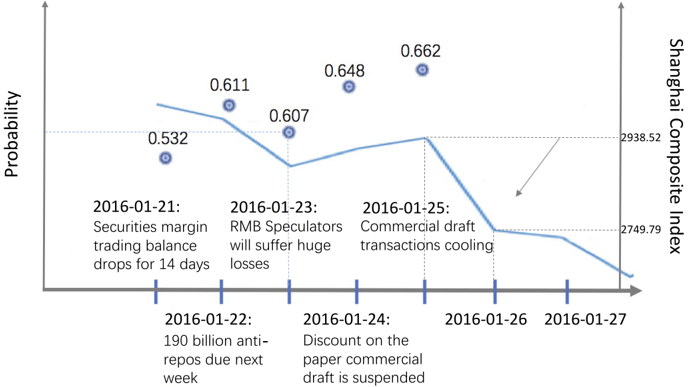

Description: This image is a line graph showing a declining trend in probability values over a series of dates from January 2016 to January 2017. The graph's horizontal axis represents dates, and the vertical axis indicates “Probability”.

The graph begins with a high probability value around 0.648. Over the following dates, the probability steadily decreases, reaching a low of approximately 0.532.  The graph appears to show a series of events related to securities margin trading, RMB speculation, and a commercial draft. The slope of the line suggests a consistent downward movement, indicating a decline in whatever is being measured by the probability values. The graph doesn't represent a logo or brand.
Document: Stock_Market_Prediction_via_Multi-Source_Multiple_Instance_Learning.pdf, Page: 2



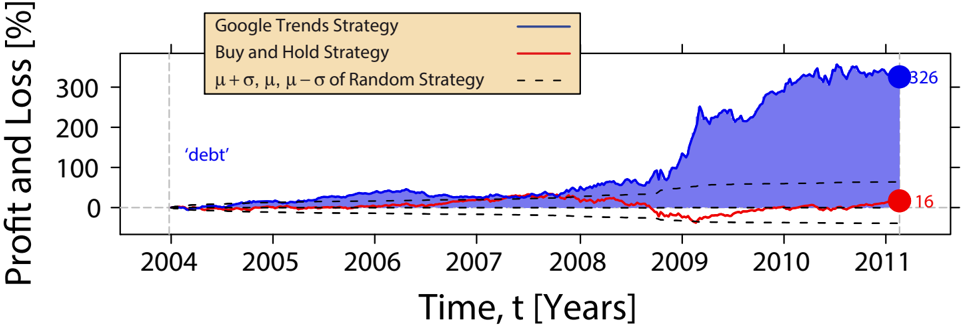

Description: This image is a line graph illustrating the performance of two investment strategies – “Google Trends Strategy” (blue line) and “Buy and Hold Strategy” (red line) – over a period from 2004 to 2011.  The graph shows the change in profit and loss (percentage) over time.

The “Google Trends Strategy” initially shows a relatively flat line, then experiences a significant upward trend, reaching a peak of approximately 326% by 2011. The “Buy and Hold Strategy” demonstrates a more consistent, moderate upward trajectory, peaking around 16% during the same period. 

The graph suggests that the “Google Trends Strategy” was significantly more volatile and generated substantial gains, albeit with greater risk, compared to the more stable “Buy and Hold Strategy”. The difference in performance between the two strategies is clearly evident throughout the time frame displayed.
Document: srep01684.pdf, Page: 2



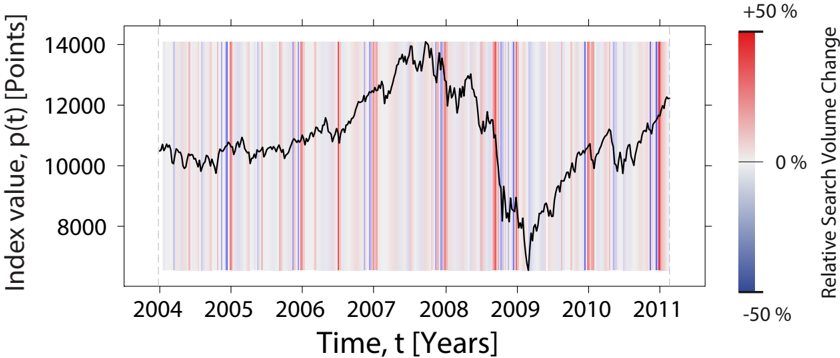

Description: This image is a line graph showing the relative search volume (p(t)) over time, indexed by year (t) from 2004 to 2011. The graph's y-axis represents the relative search volume, ranging from approximately 500 to 1400. The x-axis represents time in years.

The line itself depicts a generally upward trend, suggesting increasing search volume over the observed period. However, the line is not smooth but rather has fluctuations, indicating variability in the search volume. There are periods of significant increases and decreases, representing peaks and troughs in search demand. The graph uses a color gradient to visually represent the relative search volume, with red indicating higher search volumes and blue indicating lower ones.
Document: srep01684.pdf, Page: 2



In [34]:
prompt = "A graph with a downward trend"
res1 = table.search(prompt, vector_column_name="description_vector").with_row_id(True).limit(5)
res2 = table.search(prompt, vector_column_name="vector").with_row_id(True).limit(5)
# print(type(res1), type(res2))
reranked = reranker.rerank_multivector([res1, res2], query=prompt, deduplicate=True)
reranked

for idx, row in reranked.to_pandas().iterrows():
    if idx < 3:
        display(Image.open(row['image_uri']))
        print(f"Description: {row['description']}\nDocument: {row['document']}, Page: {row['page']}\n")

# HYBRID SEARCH WITH CLIP IMAGE EMBEDDINGS AND FTS ON GEMMA DESCRIPTIONS

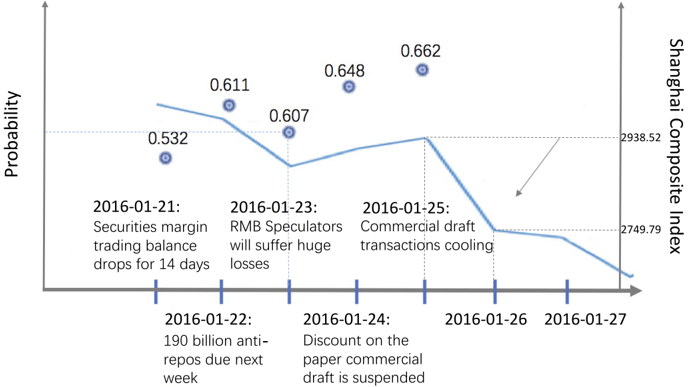

Description: This image is a line graph showing a declining trend in probability values over a series of dates from January 2016 to January 2017. The graph's horizontal axis represents dates, and the vertical axis indicates “Probability”.

The graph begins with a high probability value around 0.648. Over the following dates, the probability steadily decreases, reaching a low of approximately 0.532.  The graph appears to show a series of events related to securities margin trading, RMB speculation, and a commercial draft. The slope of the line suggests a consistent downward movement, indicating a decline in whatever is being measured by the probability values. The graph doesn't represent a logo or brand.
Document: Stock_Market_Prediction_via_Multi-Source_Multiple_Instance_Learning.pdf, Page: 2



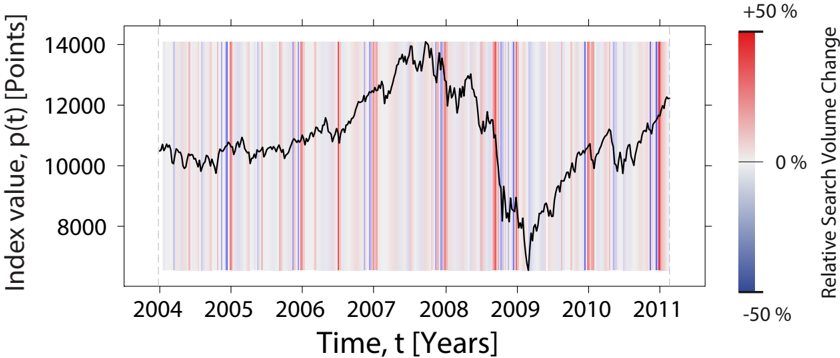

Description: This image is a line graph showing the relative search volume (p(t)) over time, indexed by year (t) from 2004 to 2011. The graph's y-axis represents the relative search volume, ranging from approximately 500 to 1400. The x-axis represents time in years.

The line itself depicts a generally upward trend, suggesting increasing search volume over the observed period. However, the line is not smooth but rather has fluctuations, indicating variability in the search volume. There are periods of significant increases and decreases, representing peaks and troughs in search demand. The graph uses a color gradient to visually represent the relative search volume, with red indicating higher search volumes and blue indicating lower ones.
Document: srep01684.pdf, Page: 2



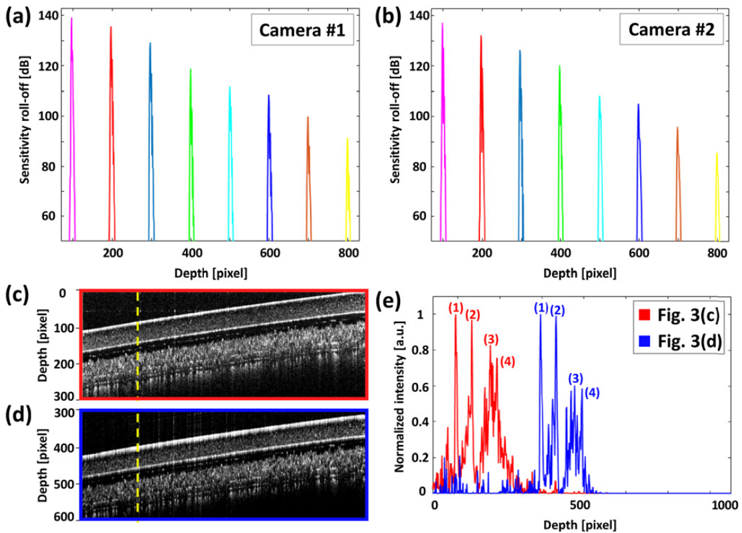

Description: This image consists of two distinct graphs and a photograph.

**Graphs:**
The first graph (blue) shows a sensitivity roll-off curve, trending downwards towards a minimum value and then rising again. The second graph (red) presents a similar, but inverted, sensitivity roll-off curve. Both curves are typically associated with optical measurement devices, particularly those used in laser scanning or interferometry. The shape of the curves suggests a specific measurement system or instrument configuration.

**Photograph:**
The photograph displays an underwater scene, likely a coral reef. The image is dark, exhibiting significant contrast variations. We can see shapes and textures indicating coral formations, sand, and possibly marine life. The lighting conditions are subdued, creating an overall hazy and shadowy appearance. Overall, it's a visual representation of an underwater ecosystem.

Given the unusual graphs, it's likely that the image is part of a technical document sho

In [37]:
query_results = table.search("A graph with a downward trend", query_type='hybrid',  vector_column_name="vector", fts_columns='description') \
                    .rerank(reranker) \
                    .limit(3).to_pydantic(ImageModel)

for result in query_results:
    display(result.image)
    print(f"Description: {result.description}\nDocument: {result.document}, Page: {result.page}\n")

# VECTOR SEARCH WITH GEMMA GENERATED DESCRIPTIONS

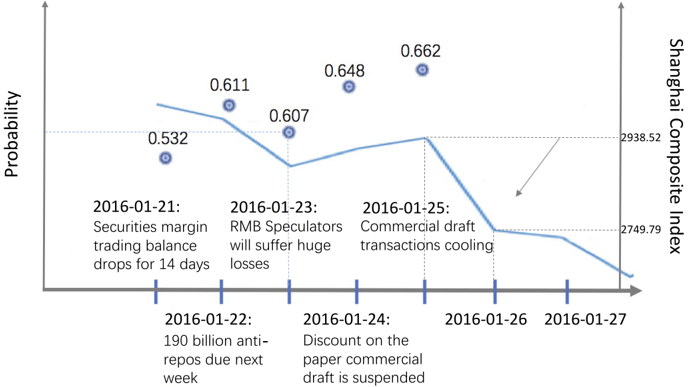

Description: This image is a line graph showing a declining trend in probability values over a series of dates from January 2016 to January 2017. The graph's horizontal axis represents dates, and the vertical axis indicates “Probability”.

The graph begins with a high probability value around 0.648. Over the following dates, the probability steadily decreases, reaching a low of approximately 0.532.  The graph appears to show a series of events related to securities margin trading, RMB speculation, and a commercial draft. The slope of the line suggests a consistent downward movement, indicating a decline in whatever is being measured by the probability values. The graph doesn't represent a logo or brand.
Document: Stock_Market_Prediction_via_Multi-Source_Multiple_Instance_Learning.pdf, Page: 2



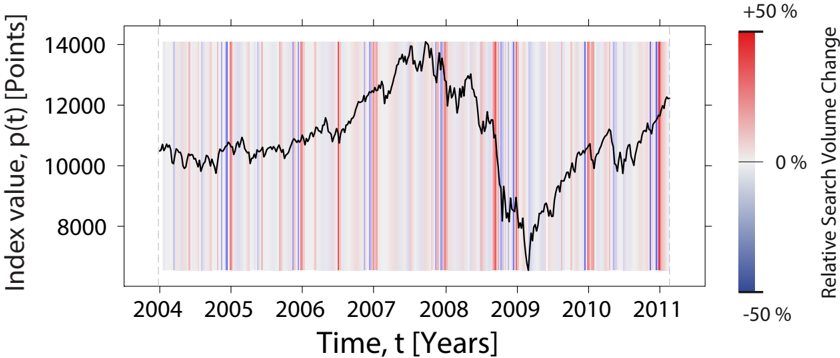

Description: This image is a line graph showing the relative search volume (p(t)) over time, indexed by year (t) from 2004 to 2011. The graph's y-axis represents the relative search volume, ranging from approximately 500 to 1400. The x-axis represents time in years.

The line itself depicts a generally upward trend, suggesting increasing search volume over the observed period. However, the line is not smooth but rather has fluctuations, indicating variability in the search volume. There are periods of significant increases and decreases, representing peaks and troughs in search demand. The graph uses a color gradient to visually represent the relative search volume, with red indicating higher search volumes and blue indicating lower ones.
Document: srep01684.pdf, Page: 2



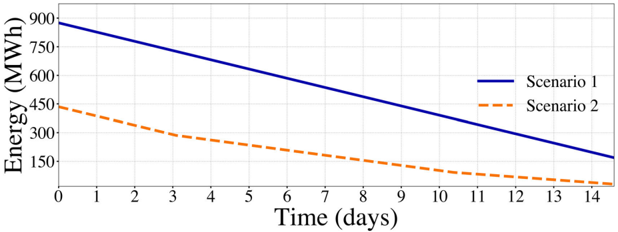

Description: This is a line graph showing a decreasing trend in energy output over time. The blue line represents "Scenario 1", indicating a decreasing energy output over time. The orange dashed line, labeled "Scenario 2," also illustrates a similar decreasing trend. Both lines start at a relatively high energy output around 750MW, then steadily decrease to nearly zero energy by the end of the 14-day period. The x-axis represents time in days, and the y-axis represents energy output in megawatt-hours (MWh).  The graph is likely visualizing an energy production or consumption pattern – potentially for a solar panel system, a battery, or some other energy system where output diminishes over time.
Document: Scalable_Resilience_Analysis_Through_Power_Systems_Co-Simulation.pdf, Page: 8



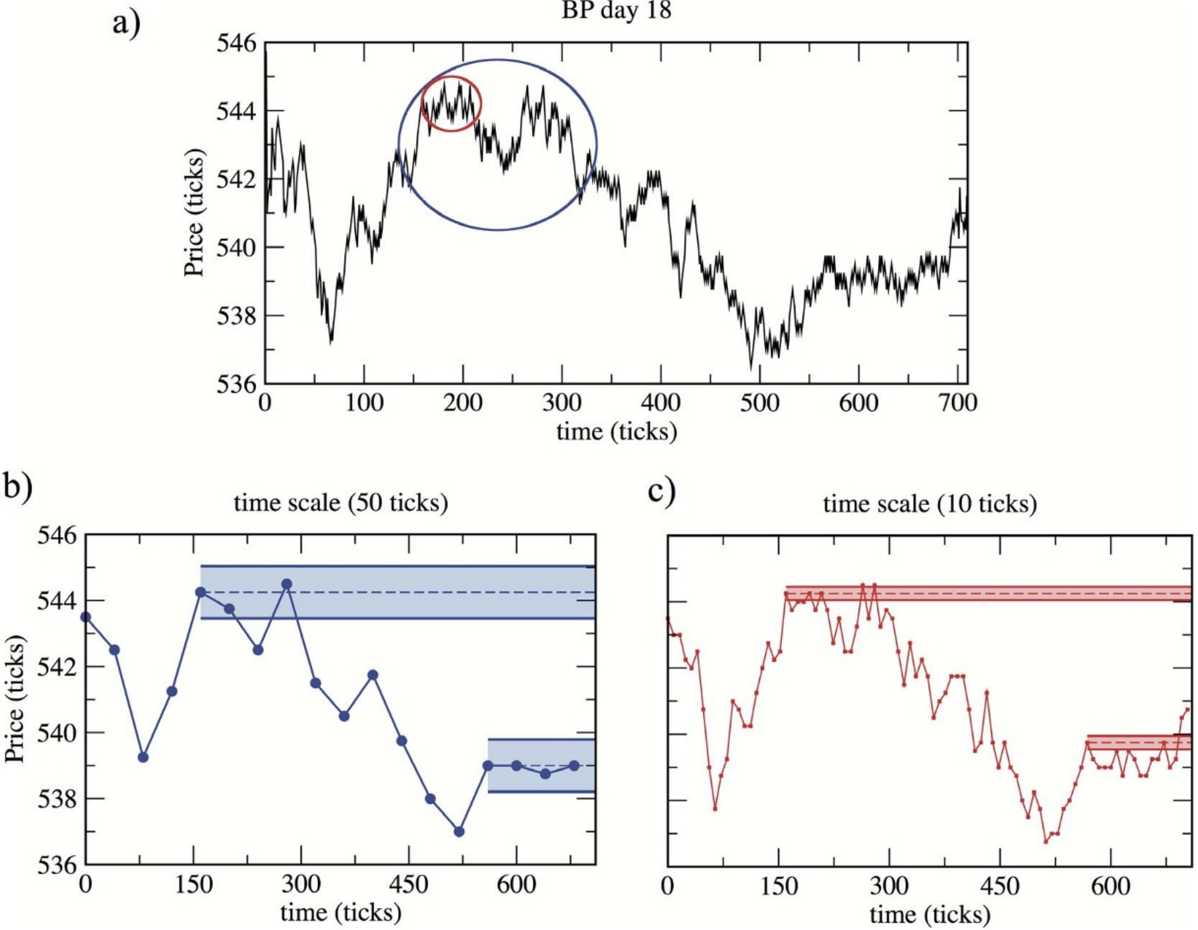

Description: c)

The image contains a graph depicting time-series data, likely representing a fluctuating “price” or some other measured value over time. The x-axis is labeled “time (ticks)” and the y-axis is labeled “Price (ticks)”.  The graph displays a cyclical pattern with peaks and troughs.

The data shows an oscillating trend with approximately a sinusoidal shape.  The graph has distinct local maxima and minima. The overall trend suggests a periodic fluctuation, possibly representing a cyclical process or a signal with repeating patterns.  There are also some irregularities and noise within the data. The use of different colored lines (blue, red, black) suggests multiple data streams, potentially representing different underlying factors or measurements linked together.
Document: srep04487.pdf, Page: 8



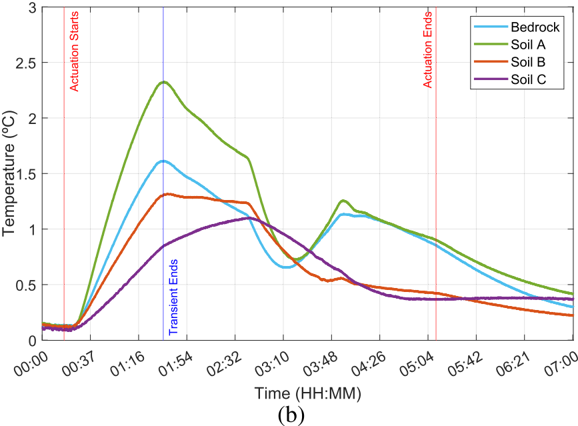

Description: This image is a graph displaying temperature readings over time. It’s a line graph with four distinct lines representing different soil types, labeled "Soil A" (green), "Soil B" (blue), and "Soil C" (red).

The x-axis represents time, measured in HH:MM (likely hours and minutes). The y-axis represents temperature in degrees Celsius (°C). Each line shows a temperature curve rising, peaking, and then gradually declining. The lines show a similar pattern of rise and fall, but with slightly different peak temperatures. The peaks of the graph appear to occur around 01:32 and 03:48.

The graph appears to be documenting temperature changes in different soil samples over a specific period. It’s a data visualization, rather than a logo or brand.
Document: Thermal_Imagery_for_Rover_Soil_Assessment_Using_a_Multipurpose_Environmental_Chamber_Under_Simulated_Mars_Conditions.pdf, Page: 8



In [8]:
query_results = table.search("A graph with a downward trend",  vector_column_name="description_vector") \
                    .rerank(reranker) \
                    .limit(5).to_pydantic(ImageModel)

for result in query_results:
    display(result.image)
    print(f"Description: {result.description}\nDocument: {result.document}, Page: {result.page}\n")

# HYBRID SEARCH WITH GEMMA GENERATED DESCRIPTION

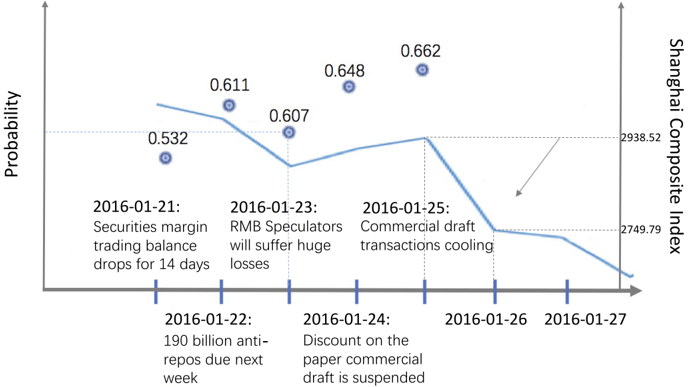

Description: This image is a line graph showing a declining trend in probability values over a series of dates from January 2016 to January 2017. The graph's horizontal axis represents dates, and the vertical axis indicates “Probability”.

The graph begins with a high probability value around 0.648. Over the following dates, the probability steadily decreases, reaching a low of approximately 0.532.  The graph appears to show a series of events related to securities margin trading, RMB speculation, and a commercial draft. The slope of the line suggests a consistent downward movement, indicating a decline in whatever is being measured by the probability values. The graph doesn't represent a logo or brand.
Document: Stock_Market_Prediction_via_Multi-Source_Multiple_Instance_Learning.pdf, Page: 2



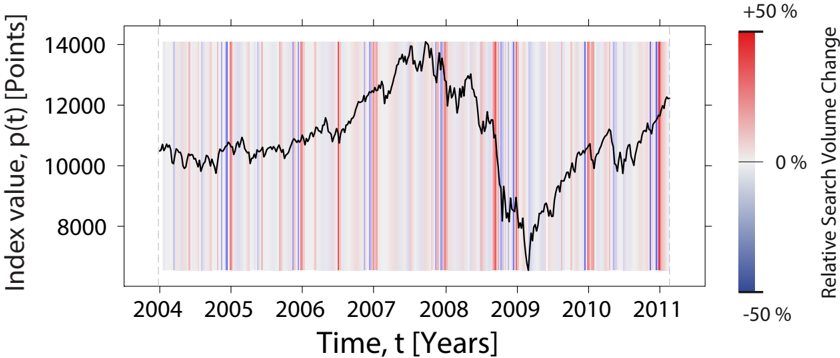

Description: This image is a line graph showing the relative search volume (p(t)) over time, indexed by year (t) from 2004 to 2011. The graph's y-axis represents the relative search volume, ranging from approximately 500 to 1400. The x-axis represents time in years.

The line itself depicts a generally upward trend, suggesting increasing search volume over the observed period. However, the line is not smooth but rather has fluctuations, indicating variability in the search volume. There are periods of significant increases and decreases, representing peaks and troughs in search demand. The graph uses a color gradient to visually represent the relative search volume, with red indicating higher search volumes and blue indicating lower ones.
Document: srep01684.pdf, Page: 2



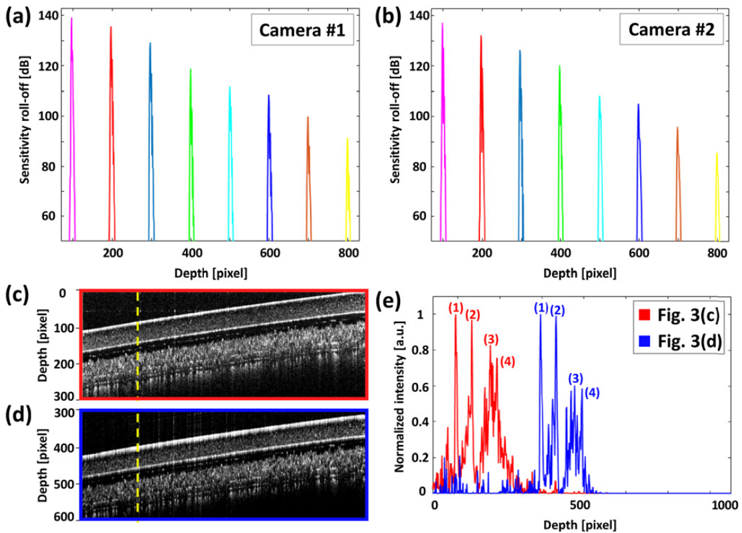

Description: This image consists of two distinct graphs and a photograph.

**Graphs:**
The first graph (blue) shows a sensitivity roll-off curve, trending downwards towards a minimum value and then rising again. The second graph (red) presents a similar, but inverted, sensitivity roll-off curve. Both curves are typically associated with optical measurement devices, particularly those used in laser scanning or interferometry. The shape of the curves suggests a specific measurement system or instrument configuration.

**Photograph:**
The photograph displays an underwater scene, likely a coral reef. The image is dark, exhibiting significant contrast variations. We can see shapes and textures indicating coral formations, sand, and possibly marine life. The lighting conditions are subdued, creating an overall hazy and shadowy appearance. Overall, it's a visual representation of an underwater ecosystem.

Given the unusual graphs, it's likely that the image is part of a technical document sho

In [41]:
query_results = table.search("A graph with a downward trend", query_type='hybrid',  vector_column_name="description_vector", fts_columns="description") \
                    .rerank(reranker) \
                    .limit(3).to_pydantic(ImageModel)

for result in query_results:
    display(result.image)
    print(f"Description: {result.description}\nDocument: {result.document}, Page: {result.page}\n")

# VECTOR SEARCH WITH CLIP IMAGE EMBEDDINGS

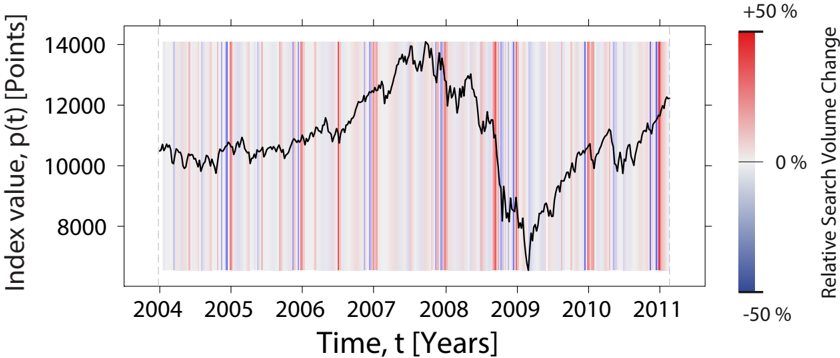

Description: This image is a line graph showing the relative search volume (p(t)) over time, indexed by year (t) from 2004 to 2011. The graph's y-axis represents the relative search volume, ranging from approximately 500 to 1400. The x-axis represents time in years.

The line itself depicts a generally upward trend, suggesting increasing search volume over the observed period. However, the line is not smooth but rather has fluctuations, indicating variability in the search volume. There are periods of significant increases and decreases, representing peaks and troughs in search demand. The graph uses a color gradient to visually represent the relative search volume, with red indicating higher search volumes and blue indicating lower ones.
Document: srep01684.pdf, Page: 2



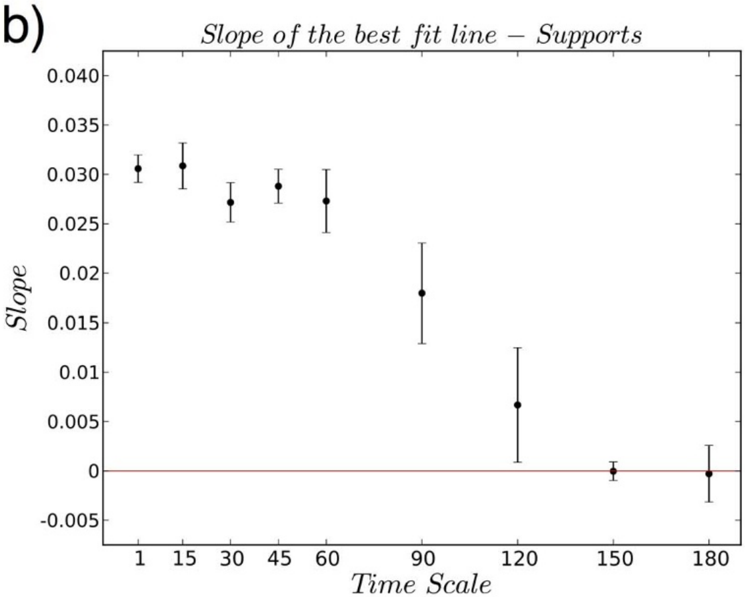

Description: This image appears to be a graph displaying a scatter plot with error bars. The data points seem to trend slightly upwards, suggesting a positive correlation, though it's a very weak one. The data range spans from approximately 1 to 180, with the x-axis possibly representing a time-series or some kind of measurement scale.

The error bars indicate uncertainty in the measurement of each point. They are quite small, suggesting that the measurements are relatively precise.  The overall plot is minimalist and appears to be showing data related to a scientific or engineering context, perhaps related to measurements or process optimization.

It isn't immediately clear if this represents a brand logo. It’s a simple dataset visualization.
Document: srep04487.pdf, Page: 5



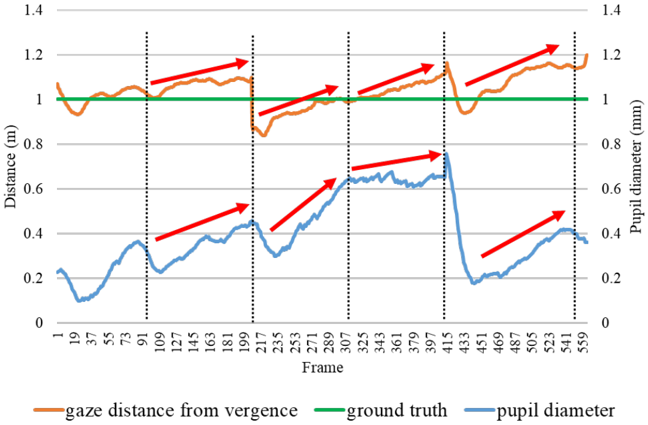

Description: The image presents a graph showing three lines representing different measurements related to eye movements and visual focus. The lines are labeled as "gaze distance from vergence", "ground truth", and "pupil diameter".

The "gaze distance from vergence" line shows a fluctuating pattern, trending upwards and then downwards over the range of the x-axis (approximately 550ms). The "ground truth" line, which is a horizontal line at approximately 1.0mm, likely represents a reference value or baseline for the ground truth. The “pupil diameter” line depicts a similar fluctuating pattern, with a minimum value at the beginning and a peak.

The graph appears to be tracking eye movements and pupil dilation, potentially as part of an eye-tracking experiment or study. It might be related to researching visual perception, attention, or visual processing.
Document: A_Hybrid_Gaze_Distance_Estimation_via_Cross-Reference_of_Vergence_and_Depth.pdf, Page: 4



In [ ]:
query_results = table.search("A graph with a downward trend",  vector_column_name="vector") \
                    .rerank(reranker) \
                    .limit(3).to_pydantic(ImageModel)

for result in query_results:
    display(result.image)
    print(f"Description: {result.description}\nDocument: {result.document}, Page: {result.page}\n")

# Docling picture extraction fun

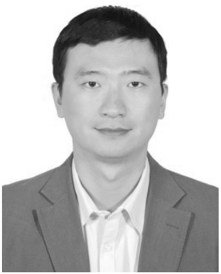

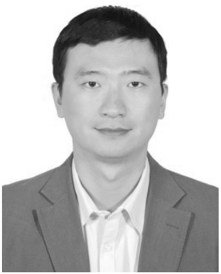

In [ ]:
# from IPython.display import display
# display(image)
 
# # Convert bytes to a BytesIO buffer
# image_buffer = io.BytesIO(base64.b64decode(image_b64))

# # Open as a PIL image
# other_img = Image.open(image_buffer)
# display(other_img)


In [ ]:
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
# sample_text = """
# The image depicts a flowchart illustrating a process involving multiple data sources and analysis stages. It appears to represent a system for analyzing text data from various sources, including social media, web news, and potentially other data streams.

# The process begins with a collection of data from these sources. This raw data then passes through a Sentiment Analyzer, which presumably assesses the emotional tone or opinion expressed within the text. A Multi-source Instance Model (M-MI) seems to be central to this process, suggesting a model designed to handle and interpret information from multiple sources simultaneously.

# Furthermore, the flowchart includes Event Extraction, indicating a stage dedicated to identifying specific events mentioned within the text. The entire process culminates in an output, likely representing the processed and analyzed information. It's a visual representation of a complex data pipeline designed to derive insights from textual data.
# """
# num_tokens = len(tokenizer.encode(sample_text))
# print(f"Number of tokens: {num_tokens}")

Number of tokens: 177
